In [117]:
import os, sys
from glob import glob
sys.path.append("../")

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from scipy.interpolate import interp1d, RegularGridInterpolator
from tqdm import *

import pickle

from scipy.integrate import quad

from grf.grf import TransitionProbabilities, PerturbedProbability, FIRAS
from grf.units import *
from grf.pk_interp import PowerSpectrumGridInterpolator

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [118]:
# Load plot style

from plot_params import params
pylab.rcParams.update(params)

cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

/Users/hongwan/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/Users/hongwan/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


# Plot of Baryon Fluctuations Variance in Linear Regime

In [119]:
# Non-linear matter power spectrum. 
pspec_lin_baryon = PowerSpectrumGridInterpolator("lin_baryon")

# Class containing results with linear baryon spectrum. 
firas_lin_baryon = FIRAS(pspec_lin_baryon)

In [120]:
z_ary = np.logspace(-4, 3, 500)

m_A_sq_ary   = firas_lin_baryon.m_A_sq(z_ary, 1e-13)
sigma_sq_ary = firas_lin_baryon._dP_dz(z_ary, 1e-13, 1e-3, 1e5, 1e-13, pdf='gaussian')[1][0]

sigma_ary = np.sqrt(sigma_sq_ary / m_A_sq_ary**2)

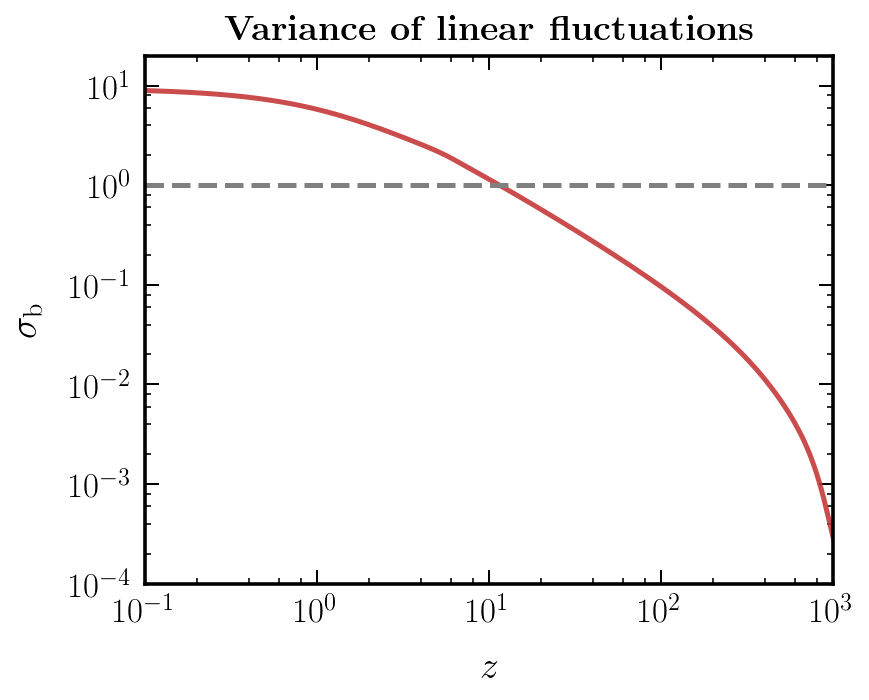

In [122]:
plt.figure()

plt.loglog()

plt.plot(z_ary, sigma_ary)
plt.axhline(y=1, ls='--', color='gray')

plt.title(r'\textbf{Variance of linear fluctuations}')

plt.xlabel(r'$z$')
plt.ylabel(r'$\sigma_\mathrm{b}$')

plt.axis([1e-1, 1e3, 1e-4, 2e1])

from matplotlib import ticker

ax = plt.gca()

locmaj = ticker.LogLocator(base=10,numticks=12) 
ax.xaxis.set_major_locator(locmaj)

locmin = ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(ticker.NullFormatter())

locmaj = ticker.LogLocator(base=10,numticks=12) 
ax.yaxis.set_major_locator(locmaj)

locmin = ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8), numticks=24)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(ticker.NullFormatter())

plt.tight_layout()

plt.savefig('../paper/draft-formalism/plots/sigma_lin_baryon.pdf')

# Gaussian vs. Homogeneous Comparison

## Analytic Estimate of Ratio of Probability with Gaussian PDF to Homogeneous Probability

In [151]:
z_ary = np.logspace(-2, 3, 500)
z_ary = z_ary[(z_ary < 6)]
m_A_sq_ary   = firas_lin_baryon.m_A_sq(z_ary, 1e-13)

sigma_sq_ary = np.array([
    firas_lin_baryon._dP_dz(z, m_Ap, 1e-3, 1e5, 1e-13, pdf='gaussian')[1][0][0]
    for (z,m_Ap) in zip(z_ary,m_A_sq_ary)
]) / m_A_sq_ary**2

delta_0_ary = m_A_sq_ary / m_A_sq_ary[0] - 1.

from scipy.special import erf

def error(sigma_sq_ary, delta_0_ary):
    
    term_1 = 0.5 * (erf(1/np.sqrt(2*sigma_sq_ary)) + erf(delta_0_ary / np.sqrt(2*sigma_sq_ary)))
    term_2 = 5 * np.sqrt(sigma_sq_ary) / (6 * np.sqrt(2*np.pi)) * (
        np.exp(-1/(2*sigma_sq_ary)) - np.exp(-delta_0_ary**2 / (2*sigma_sq_ary))
    )
    
    return term_1 + term_2

## Computed ratio

In [133]:
m_A_sq_ary_full = np.logspace(np.log10(3.185e-34), -24, 100)

test_gaussian = np.array([
    firas_lin_baryon.P_tot_perturb([1e-13], 1, np.sqrt(m_A_sq), pdf='gaussian', n_z_bins=100)[2] 
    for m_A_sq,z in zip(tqdm_notebook(m_A_sq_ary_full), z_ary_full)
]).flatten()

test_homo = np.array(
    [firas_lin_baryon.P_tot([1e-13], 1, np.sqrt(m_A_sq))[2][0,0] for m_A_sq in tqdm_notebook(m_A_sq_ary_full)]
)

## Plot of the Ratio

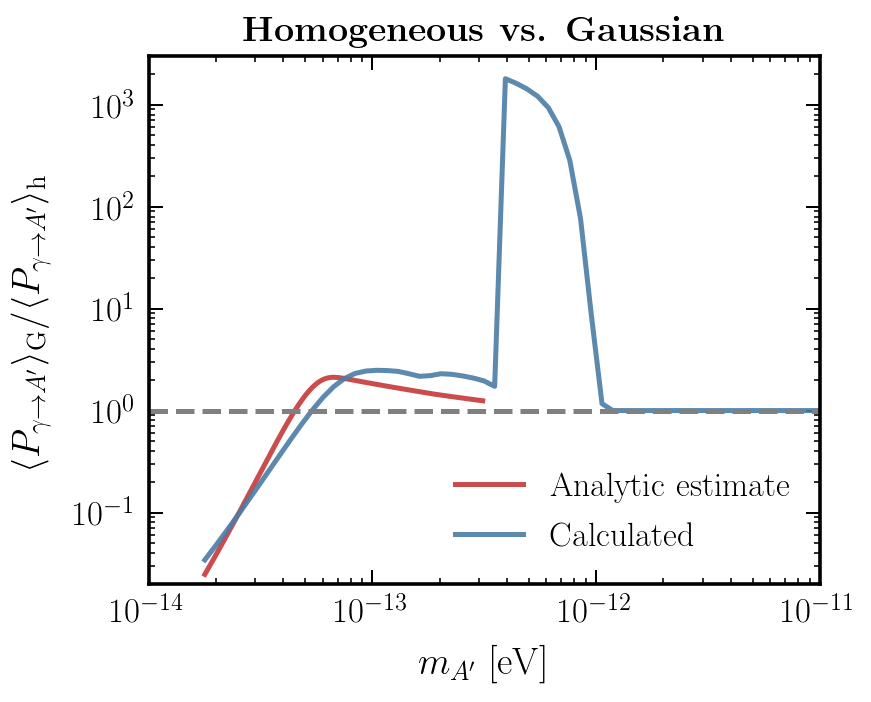

In [134]:
plt.figure()

plt.xscale('log')
plt.yscale('log')

plt.plot(np.sqrt(m_A_sq_ary)*1e3, error(sigma_sq_ary, delta_0_ary), label='Analytic estimate')
plt.plot(np.sqrt(m_A_sq_ary_full)*1e3, test_gaussian/test_homo, label='Calculated')
plt.axhline(y=1., ls='--', color='gray')

plt.title(r'\textbf{Homogeneous vs. Gaussian}')

plt.xlabel(r'$m_{A^\prime}$ [eV]')
plt.ylabel(r'$\langle P_{\gamma \to A^\prime} \rangle_\mathrm{G} / \langle P_{\gamma \to A^\prime} \rangle_\mathrm{h}$')

plt.axis([1e-14, 1e-11, 2e-2, 3e3])

plt.legend()

from matplotlib import ticker

ax = plt.gca()

locmaj = ticker.LogLocator(base=10,numticks=12) 
ax.xaxis.set_major_locator(locmaj)

locmin = ticker.LogLocator(base=10.0,subs=np.arange(0, 1.1, 0.1),numticks=12)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(ticker.NullFormatter())

plt.tight_layout()

plt.savefig('../paper/draft-formalism/plots/homo_vs_gauss_error.pdf')



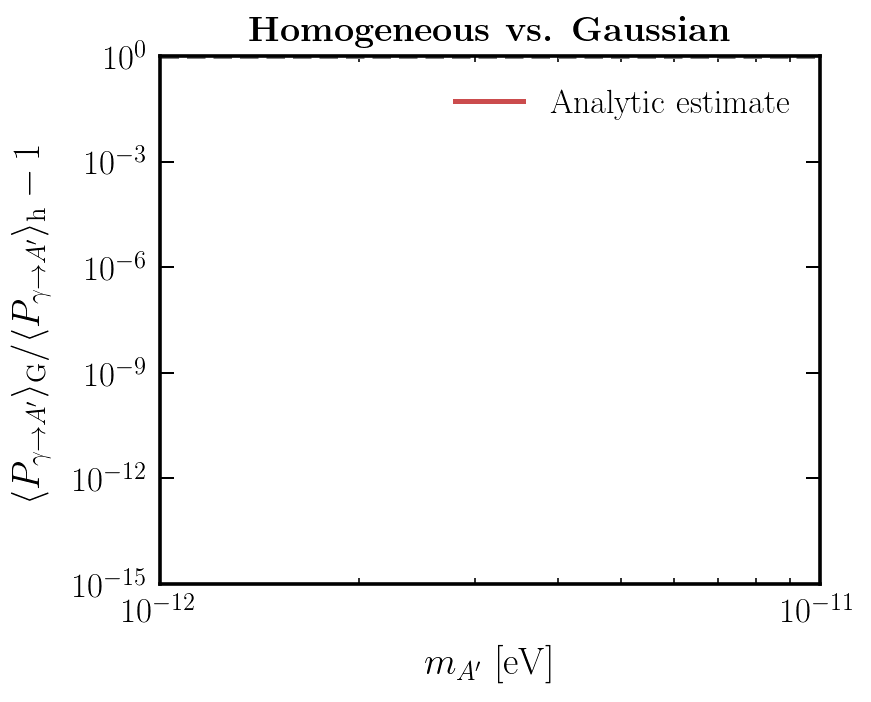

In [146]:
plt.figure()

plt.xscale('log')
plt.yscale('log')

plt.plot(np.sqrt(m_A_sq_ary)*1e3, error(sigma_sq_ary, delta_0_ary) - 1., label='Analytic estimate')
# plt.plot(np.sqrt(m_A_sq_ary_full)*1e3, test_gaussian/test_homo - 1., label='Calculated')
plt.axhline(y=1., ls='--', color='gray')

plt.title(r'\textbf{Homogeneous vs. Gaussian}')

plt.xlabel(r'$m_{A^\prime}$ [eV]')
plt.ylabel(r'$\langle P_{\gamma \to A^\prime} \rangle_\mathrm{G} / \langle P_{\gamma \to A^\prime} \rangle_\mathrm{h} - 1$')

plt.axis([1e-12, 1e-11, 1e-15, 1.])

plt.legend()

from matplotlib import ticker

ax = plt.gca()

locmaj = ticker.LogLocator(base=10,numticks=12) 
ax.xaxis.set_major_locator(locmaj)

locmin = ticker.LogLocator(base=10.0,subs=np.arange(0, 1.1, 0.1),numticks=12)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(ticker.NullFormatter())

plt.tight_layout()

In [150]:
error(sigma_sq_ary, delta_0_ary)

array([0.0247528 , 0.0247853 , 0.02481861, 0.02485274, 0.0248877 ,
       0.02492352, 0.02496023, 0.02499783, 0.02503639, 0.02507589,
       0.02511638, 0.02515787, 0.02520038, 0.02524394, 0.02528861,
       0.0253344 , 0.02538133, 0.02542943, 0.02547873, 0.02552927,
       0.0255811 , 0.02563424, 0.02568871, 0.02574456, 0.02580182,
       0.02586053, 0.02592076, 0.02598252, 0.02604585, 0.0261108 ,
       0.02617741, 0.02624573, 0.02631584, 0.02638775, 0.02646151,
       0.02653718, 0.02661481, 0.02669446, 0.02677622, 0.02685975,
       0.02694564, 0.02703398, 0.02712464, 0.02721769, 0.02731325,
       0.02741134, 0.02751205, 0.02761544, 0.02772159, 0.02783059,
       0.02794257, 0.02805758, 0.02817571, 0.02829704, 0.02842167,
       0.02854972, 0.02868135, 0.0288166 , 0.02895559, 0.02909843,
       0.02924524, 0.02939616, 0.02955139, 0.02971098, 0.02987509,
       0.03004385, 0.03021742, 0.03039595, 0.03057971, 0.03076876,
       0.0309633 , 0.03116351, 0.03136957, 0.03158167, 0.03180